In [106]:
# import libraries
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, SnowballStemmer, WordNetLemmatizer
nltk.download('stopwords')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve, accuracy_score



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\redinger\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Date Cleaning:
Selected articles were indicated, but irrelevant articles were not. 

In [5]:
# Create new column names because text file has no header
col_names = ["Type", "Author", "Year", "Title", "Journal Name", "Volume", "Issue", "Pages", "URL", "Keywords", "Abstract", "DOI", "PDF Name"]

# Convert text files into a dataframe
silver_yes = pd.read_csv('Hypopthalmichthys_molitrix_yes.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
silver_all = pd.read_csv('Hypopthalmichthys_molitrix_all.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
bighead_yes = pd.read_csv('Hypopthalmichthys_nobilis_yes.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')
bighead_all = pd.read_csv('Hypopthalmichthys_nobilis_all.txt', sep = '\t', header = None, dtype = str, names = col_names, quotechar = '"')

# Check entries of selected articles
print(len(silver_yes))
print(len(silver_all))
print(len(bighead_yes))
print(len(bighead_all))


123
444
110
197


In [6]:
# Combine data with selected articles
carp_yes = pd.concat([silver_yes, bighead_yes], ignore_index = True)

# Combine all article - duplicates removed in next step to get irrelevant articles
carp_concat = pd.concat([silver_yes, silver_all, bighead_yes, bighead_all], ignore_index = True)

print(len(carp_yes))
print(len(carp_concat))


233
874


In [7]:
# Drop duplicates to get unselected articles
carp_no = carp_concat.drop_duplicates(keep = False, ignore_index = True)

print(len(carp_no))


408


In [8]:
# subset and select by columns
columns = ["Author", "Year", "Title", "Journal Name", "Volume", "Issue", "Pages", "Abstract"]

carp_yes = carp_yes[columns]
carp_no = carp_no[columns]


In [9]:
# add category columns
carp_yes['categories'] = 'yes'
carp_no['categories'] = 'no'


In [10]:
# combine df
carp_all = pd.concat([carp_yes, carp_no], ignore_index = True)

print(len(carp_all))

641


In [9]:
# Export to csv files
carp_all.to_csv('hypopthalmichthys_selected_articles.csv', index = False)


#### Data Prep

In [11]:
# Import csv files
carp_file = pd.read_csv('hypopthalmichthys_selected_articles.csv', dtype = str)

print(len(carp_file))


641


In [12]:
# Drop any abstracts with NAs
carp_file.dropna(subset = ['Abstract'], inplace = True)

print(len(carp_file))


641


In [13]:
# Create new encoding for category column
label_encoder = LabelEncoder()
carp_file['encoding'] = label_encoder.fit_transform(carp_file['categories'])
carp_file.head()


,Author,Year,Title,Journal Name,Volume,Issue,Pages,Abstract,categories,encoding
0,"Aldridge, C. A., and E. C. Boone",2022,Simple models to quickly estimate the probable...,River Research and Applications,38,6,1154-1166,Species distribution models provide biologists...,yes,1
1,"Banan, A., A. Nasiri, and A. Taheri-Garavand",2020,Deep learning-based appearance features extrac...,Aquacultural Engineering,89,NaN,NaN,Fish species identification is vital for aquac...,yes,1
2,"Barnes, M. A., W. L. Chadderton, C. L. Jerde, ...",2021,Environmental conditions influence edna partic...,Environmental DNA,3,3,643-653,Knowledge about the size of environmental DNA ...,yes,1
3,"Behera, B. K., A. K. Bera, P. Paria, A. Das, P...",2018,Identification and pathogenicity of plesiomona...,Aquaculture,493,NaN,314-318,Plesiomonas shigelloides was isolated from dis...,yes,1
4,"Borland, L. K., C. J. Mulcahy, B. A. Bennie, D...",2020,Using markov chains to quantitatively assess m...,Natural Resource Modeling,33,4,NaN,Natural resource managers use barriers to dete...,yes,1


#### Text Processing

In [14]:
# Removal of HTML tags and whitespace
carp_file1 = carp_file

# Function to remove HTML tags
def basic_clean(text):
    text = re.sub(r'<.*?>', '', text)
    text = text.strip()
    return text
    
carp_file1['Title'] = carp_file1['Title'].apply(basic_clean)
carp_file1['Abstract'] = carp_file1['Abstract'].apply(basic_clean)


In [15]:
# Remove punctuation, remove special characters, and remove stopwords
carp_file2 = carp_file1

# Get the set of English stopwords
stop_words = set(stopwords.words('english'))

# Function to clean text
def advanced_clean(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'[^\w\s]', '', text)

    # Function to remove stopwords from text
    def remove_stopwords(text):
        # Tokenize the text
        tokens = nltk.word_tokenize(text)
        # Filter out stopwords
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        # Reconstruct the text without stopwords
        text_without_stopwords = ' '.join(filtered_tokens)
        return text_without_stopwords

    text = remove_stopwords(text)
    
    return text

carp_file2['Title'] = carp_file2['Title'].apply(advanced_clean)
carp_file2['Abstract'] = carp_file2['Abstract'].apply(advanced_clean)



In [16]:
# Stemming
carp_file3 = carp_file2

stemmer = SnowballStemmer(language = 'english')
def stem_words(text):
    text = " ".join([stemmer.stem(word) for word in text.split()])
    return text
    
carp_file3['Title'] = carp_file3['Title'].apply(stem_words)
carp_file3['Abstract'] = carp_file3['Abstract'].apply(stem_words)


In [17]:
# Lemmatize
carp_file4 = carp_file2

lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    return text
    
carp_file4['Title'] = carp_file4['Title'].apply(stem_words)
carp_file4['Abstract'] = carp_file4['Abstract'].apply(stem_words)


In [18]:
# Remove numerical values
carp_file5 = carp_file2

# Function to remove HTML tags
def remove_digits(text):
    text = re.sub(r'\d+', '', text)
    return text
    
carp_file5['Title'] = carp_file5['Title'].apply(remove_digits)
carp_file5['Abstract'] = carp_file5['Abstract'].apply(remove_digits)


#### Machine Learning Models

In [49]:
# Balance data categories
print(len(carp_file1))

# Count the number of rows in each category
category_counts = carp_file1['encoding'].value_counts()

# Find the minority category
minority_category = category_counts.idxmin()

# Get the size of the minority category
minority_category_size = category_counts[minority_category]

# Sample rows from the majority category to match the size of the minority category
majority_category_rows = carp_file1[carp_file1['encoding'] != minority_category]
balanced_majority_category_rows = majority_category_rows.sample(n=minority_category_size, random_state=42)

# Get the minority category rows
minority_category_rows = carp_file1[carp_file1['encoding'] == minority_category]

# Concatenate the minority and balanced majority category rows
carp_file1 = pd.concat([minority_category_rows, balanced_majority_category_rows])

print(len(carp_file1))

,Author,Year,Title,Journal Name,Volume,Issue,Pages,Abstract,categories,encoding
0,"Aldridge, C. A., and E. C. Boone",2022,simpl model quick estim probabl rang datalimit...,River Research and Applications,38,6,1154-1166,speci distribut model provid biologist insight...,yes,1
1,"Banan, A., A. Nasiri, and A. Taheri-Garavand",2020,deep learningba appear featur extract autom ca...,Aquacultural Engineering,89,NaN,NaN,fish speci identif vital aquacultur fisheri in...,yes,1
2,"Barnes, M. A., W. L. Chadderton, C. L. Jerde, ...",2021,environ condit influenc edna particl size dist...,Environmental DNA,3,3,643-653,knowledg size environ dna edna ednabear partic...,yes,1
3,"Behera, B. K., A. K. Bera, P. Paria, A. Das, P...",2018,identif pathogen plesiomona shigelloid silver ...,Aquaculture,493,NaN,314-318,plesiomona shigelloid isol disea silver carp k...,yes,1
4,"Borland, L. K., C. J. Mulcahy, B. A. Bennie, D...",2020,use markov chain quantit assess movement patte...,Natural Resource Modeling,33,4,NaN,natur resourc manag use barrier deter movement...,yes,1
...,...,...,...,...,...,...,...,...,...,...
299,"Fang, D. A., Y. F. Zhou, P. Ren, Y. X. Peng, X...",2022,status silver carp resourc complementari mecha...,Frontiers in Marine Science,8,NaN,NaN,global climat environ variabl induc fish adapt...,no,0
388,"Lin, C., Z. D. Deng, X. Shi, H. Dai, J. Wang, ...",2022,mutual promot constrain disentangl superimpo e...,Freshwater Biology,67,8,1468-1480,global climat chang speci inva human activ con...,no,0
326,"Hamilton, M. G., W. Mekkawy, B. K. Barman, M. ...",2021,genet relationship among founder silver carp h...,Aquaculture,540,NaN,NaN,silver carp hypophthalmichthi molitrix import ...,no,0
301,"Fang, M. X., S. B. Xiong, Y. Hu, T. Yin, and J...",2019,vitro pepsin digest silver carp hypophthalmich...,Food Hydrocolloids,95,NaN,152-160,addit microbi transglutamina mtgase surimi gel...,no,0


In [108]:
# X = carp_file1[['Title', 'Abstract']]
# y = carp_file1['encoding']
carp_file1["TitleAbstract"] = carp_file1["Title"] + ' ' + carp_file1["Abstract"]

# Split the data into training and test sets
X_train_title, X_test_title, y_train, y_test = train_test_split(carp_file1['Title'], carp_file1['encoding'], test_size=0.2, random_state=42)
X_train_abstract, X_test_abstract, _, _ = train_test_split(carp_file1['Abstract'], carp_file1['encoding'], test_size=0.2, random_state=42)
X_train_combined, X_test_combined, _, _ = train_test_split(carp_file1['TitleAbstract'], carp_file1['encoding'], test_size=0.2, random_state=42)

In [113]:
# Vectorize text data
vectorizer = TfidfVectorizer()

X_train_title_vec = vectorizer.fit_transform(X_train_title)
X_test_title_vec = vectorizer.transform(X_test_title)

X_train_abstract_vec = vectorizer.fit_transform(X_train_abstract)
X_test_abstract_vec = vectorizer.transform(X_test_abstract)

X_train_combined_vec = vectorizer.fit_transform(X_train_combined)
X_test_combined_vec = vectorizer.transform(X_test_combined)

0.6464646464646465
0.6607387140902874
0.6276595744680851


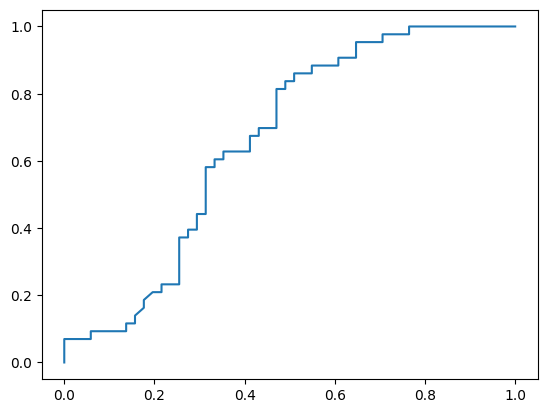

In [110]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_title_vec, y_train)

# Predict probabilities and classes
y_pred = mod.predict(X_test_title_vec)
y_pred_prob = mod.predict_proba(X_test_title_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)


0.7
0.7168262653898769
0.6808510638297872


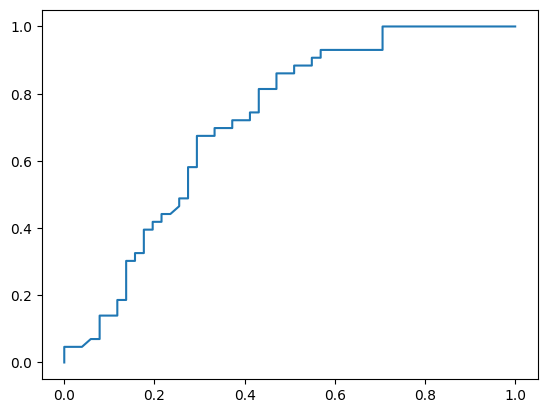

In [111]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_abstract_vec, y_train)

# Predict probabilities and classes
y_pred = mod.predict(X_test_abstract_vec)
y_pred_prob = mod.predict_proba(X_test_abstract_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)

0.6990291262135923
0.7250341997264023
0.6702127659574468


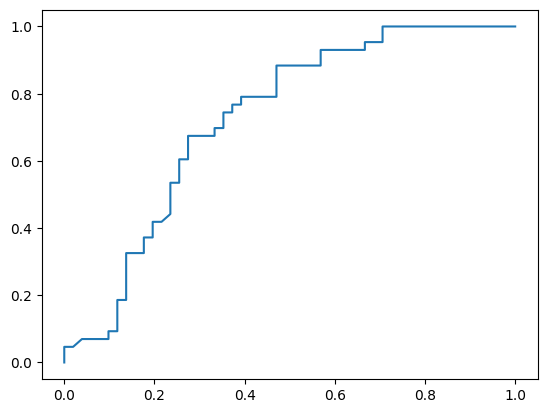

In [114]:
# Fit logistic regression model
mod = LogisticRegression()
mod.fit(X_train_combined_vec, y_train_combined)

# Predict probabilities and classes
y_pred = mod.predict(X_test_combined_vec)
y_pred_prob = mod.predict_proba(X_test_combined_vec)[:, 1]

# Calculate metrics
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)
accuracy = accuracy_score(y_test, y_pred)
print(f1)
print(auc)
print(accuracy)

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr)